In [1]:
# Import packages
%reload_ext autoreload
%autoreload 2

import warnings
warnings.filterwarnings('ignore')

In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt
import scarlet

import kuaizi as kz
from kuaizi.display import display_single, display_rgb, SEG_CMAP
from kuaizi.detection import Data
from kuaizi.utils import padding_PSF

import unagi

import astropy.units as u
from astropy import wcs
from astropy.io import fits
from astropy.table import Table, Column, vstack
from astropy.coordinates import SkyCoord, match_coordinates_sky
from astropy.convolution import convolve, Gaussian2DKernel

In [3]:
from kuaizi.fit import ScarletFitter, fitting_obs_tigress

In [4]:
env_dict = {'project': 'HSC', 'name': 'LSBG', 'data_dir': '/scratch/gpfs/jiaxuanl/Data'}
kz.utils.set_env(**env_dict)
kz.utils.set_matplotlib(style='default', usetex=False)

In [5]:
lsbg_cat = Table.read('/scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Catalog/candy/candy_cutout_cat_candy.fits')
print('# of LSBGs:', len(lsbg_cat))

# of LSBGs: 781


In [196]:
lsbg = lsbg_cat[lsbg_cat['viz-id']==203][0] # 12 # 69

In [197]:
lsbg['viz-id']

203

In [198]:
prefix = 'LSBG'
channels = 'griz'
index = lsbg['viz-id']

bright = (lsbg['mag_auto_i'] < 17.5)
print('Bright =', bright)

lsbg_coord = SkyCoord(ra=lsbg['ra'], dec=lsbg['dec'], unit='deg')
cutout = [fits.open(f"{lsbg['prefix']}_{band}.fits") for band in channels]
psf_list = [fits.open(f"{lsbg['prefix']}_{band}_psf.fits") for band in channels]

images = np.array([hdu[1].data for hdu in cutout])
# note: all bands share the same WCS here, but not necessarily true.
w = wcs.WCS(cutout[0][1].header)
weights = 1.0 / np.array([hdu[3].data for hdu in cutout])
weights[np.isinf(weights)] = 0.0
psf_pad = padding_PSF(psf_list)  # Padding PSF cutouts from HSC
psfs = scarlet.ImagePSF(np.array(psf_pad))
# saturation mask and interpolation mask from HSC S18A
sat_mask = np.array([sum(unagi.mask.Mask(
    hdu[2].data, data_release='s18a').extract(['INTRP', 'SAT'])) for hdu in cutout])
data = Data(images=images, weights=weights, masks=sat_mask,
            wcs=w, psfs=psfs, channels=channels)

Bright = False


In [199]:
# fitter = ScarletFitter(method='wavelet', tigress=True, bright=bright,
#                        starlet_thresh=0.3, min_grad=-0.2,
#                        monotonic=True, bkg=True,
#                        variance=0.015**2, 
#                        scales=[0, 1, 2, 3, 4],
#                        prefix='candy', 
#                        log_dir='./log/candy/', 
#                        figure_dir='./Figure/candy/',
#                        model_dir='./Model/candy/spergel/',
#                        index=lsbg['viz-id'], 
#                        show_figure=True)
# fitter.load_data(data, lsbg_coord)

fitter = ScarletFitter(method='spergel', tigress=True, bright=bright,
                       starlet_thresh=0.5, min_grad=-0.1, bkg=True,
#                        monotonic=True, 
#                        variance=0.015**2, 
#                        scales=[0, 1, 2, 3, 4],
                       prefix='candy', 
                       log_dir='./log/candy/', 
                       figure_dir='./Figure/candy/',
                       model_dir='./Model/candy/spergel/',
                       index=lsbg['viz-id'], 
                       show_figure=True)

# fitter = ScarletFitter(method='vanilla', tigress=True, bright=bright,
#                        starlet_thresh=0.3, min_grad=-0.02, bkg=True,
# #                        monotonic=True,
# #                        variance=0.015**2, 
# #                        scales=[0, 1, 2, 3, 4],
#                        prefix='candy', 
#                        log_dir='./log/candy/', 
#                        figure_dir='./Figure/candy/',
#                        model_dir='./Model/candy/spergel/',
#                        index=lsbg['viz-id'], 
#                        show_figure=True)

fitter.load_data(data, lsbg_coord)

  - Detect sources and make mask
    Query GAIA stars...
    Taking Gaia catalogs stored in `Tigress`
    No Gaia stars are masked.
    Detected 149 objects
    Detected 126 objects
    Detected 75 objects
  - Added Spergel profile with bbox = (4, 221, 221)
    Added constant sky background
    Total number of sources: 6
  - Optimizing scarlet model...
    Optimizaiton: Succeed for e_rel = 0.0001 with 98 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0005 with 178 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0002 with 258 iterations! Try higher accuracy!
  - After 258 iterations, logL = 1001206.47
    Elapsed time for fitting: 100.37 s
  - Components [0] are considered as the target galaxy.
  - Masking stars and other sources that are modeled, to deal with leaky flux issue.
  - Saving the results as /scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Model/candy/spergel/candy-203-trained-model-spergel.df


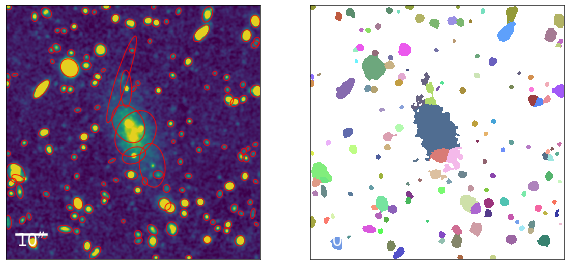

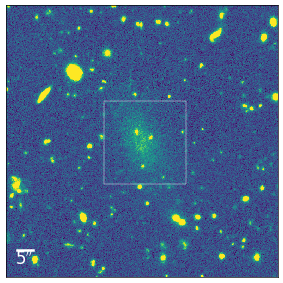

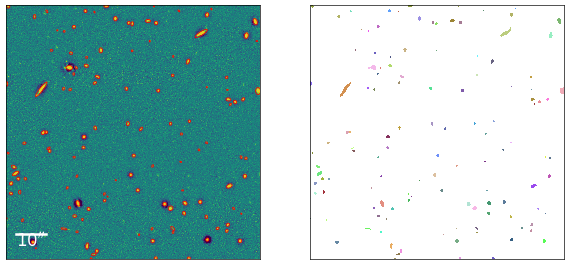

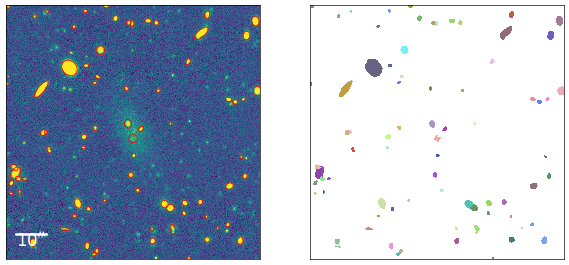

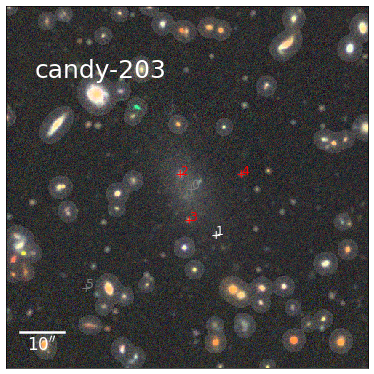

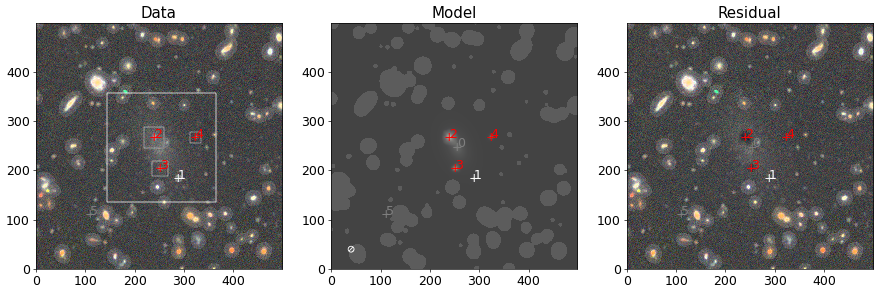

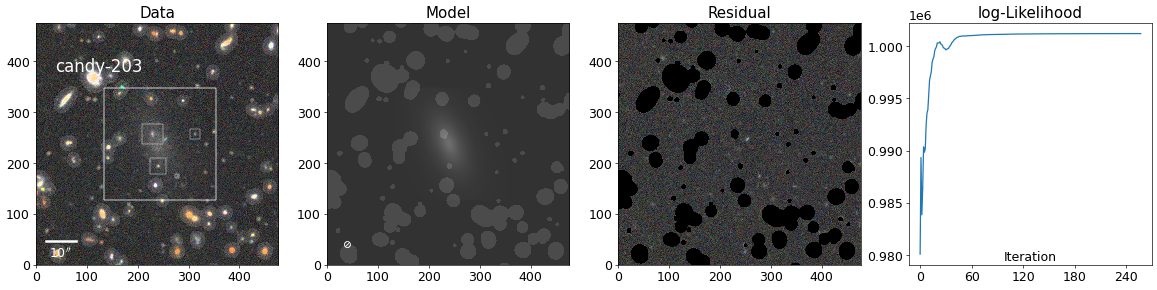

In [200]:
fitter.fit()

In [204]:
fitter.blend.sources[0].parameters

(Parameter([0.2349377 , 0.37621285, 0.46071712, 0.51563445]),
 Parameter([247.63307305, 249.64605574]),
 Parameter([[0.91952767]]),
 Parameter([[44.40155798]]),
 Parameter([-0.23557979, -0.22452049]))

In [205]:
fitter.blend.sources[0].parameters[3] * 0.168

Parameter([[7.45946174]])

In [206]:
from kuaizi.measure import nu_to_n
nu_to_n(fitter.blend.sources[0].parameters[2])

Parameter([[0.82080728]])

#### Step-by-step

In [160]:
fitter._first_gaia_search()

    Query GAIA stars...
    Taking Gaia catalogs stored in `Tigress`
    3 stars from Gaia are masked!


In [161]:
# Set the weights of saturated star centers to zero
# In order to make the box size estimation more accurate.
temp = np.copy(fitter.data.masks)
for i in range(len(fitter.data.channels)):
    temp[i][~fitter.msk_star_ori.astype(bool)] = 0
    fitter.data.weights[i][temp[i].astype(bool)] = 0.0

    Detected 80 objects


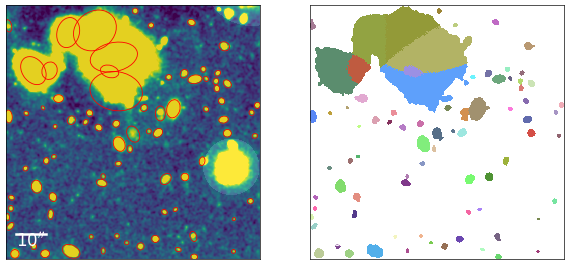

In [162]:
# Replace the vanilla detection with a convolved vanilla detection
first_dblend_cont = 0.07 if max(
    fitter.data.images.shape) * fitter.pixel_scale > 200 else 0.002

if fitter.method == 'wavelet':
    first_dblend_cont = 0.07 if max(
    fitter.data.images.shape) * fitter.pixel_scale > 200 else 0.002
        
fitter._first_detection(first_dblend_cont, conv_radius=2, lvl=4)

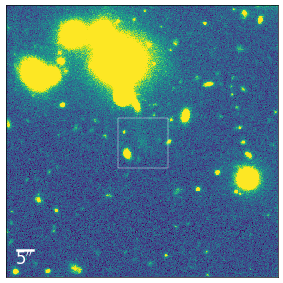

In [163]:
fitter._estimate_box(fitter.cen_obj)

In [164]:
fitter._mask_stars_outside_box()

    3 stars from Gaia are masked!


    Detected 79 objects


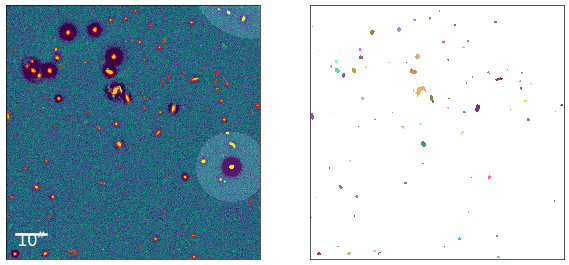

In [165]:
fitter._cpct_obj_detection()

In [166]:
from kuaizi.display import draw_circles

    Detected 42 objects


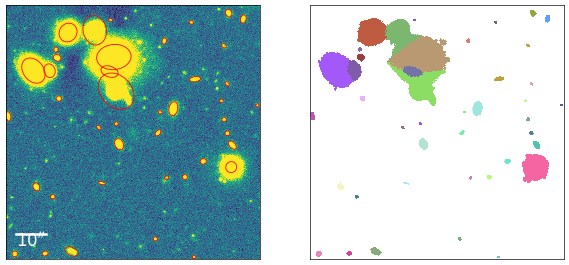

In [167]:
fitter._big_obj_detection()

In [168]:
fitter._merge_catalogs()

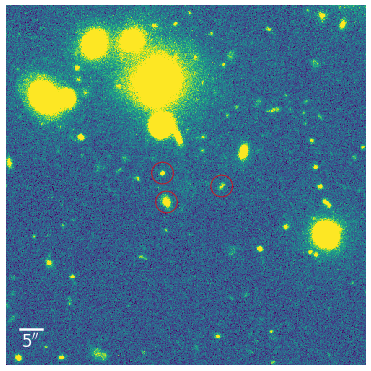

In [169]:
draw_circles(fitter.data.images[0], fitter.obj_cat_big)

In [170]:
fitter._construct_obs_frames()

In [171]:
# src = fitter.cen_obj

In [172]:
fitter._add_central_source(min_grad=fitter.min_grad, thresh=0.1)
fitter._add_other_sources(min_grad=0.1, thresh=0.1)

  - Added Spergel profile with bbox = (4, 200, 200)
    Added constant sky background
    Total number of sources: 5


[<AxesSubplot:title={'center':'Data'}>,
 <AxesSubplot:title={'center':'Model'}>,
 <AxesSubplot:title={'center':'Residual'}>]

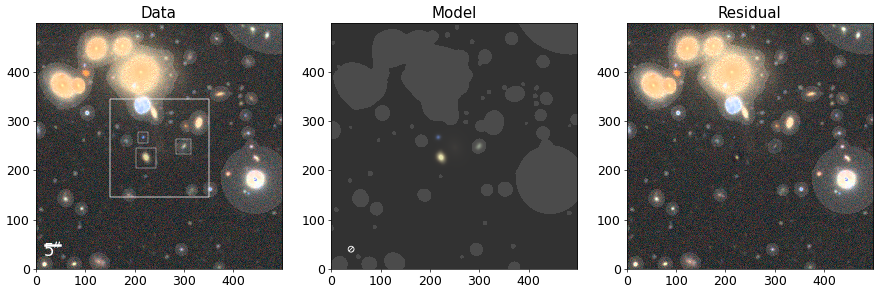

In [173]:
kz.display.display_scarlet_model(
    fitter.blend,
#     show_ind=[0],
    #zoomin_size=50,
    minimum=-0.2,
    stretch=0.9,
    add_boxes=True,
    channels='griz',
    show_mask=False,
    show_mark=False, 
    show_loss=False)

  - Optimizing scarlet model...
    Optimizaiton: Succeed for e_rel = 0.0001 with 103 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0005 with 183 iterations! Try higher accuracy!
    Optimizaiton: Succeed for e_rel = 0.0002 with 263 iterations! Try higher accuracy!
  - After 263 iterations, logL = 946877.65
    Elapsed time for fitting: 85.63 s


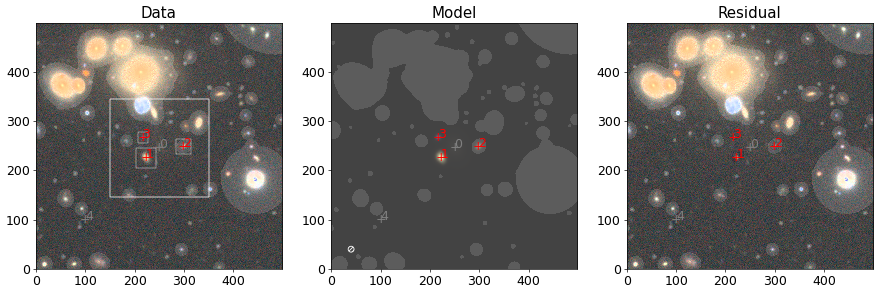

In [174]:
fitter._optimize()

  - Components [0] are considered as the target galaxy.
  - Masking stars and other sources that are modeled, to deal with leaky flux issue.
  - Saving the results as /scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Model/candy/spergel/candy-771-trained-model-spergel.df


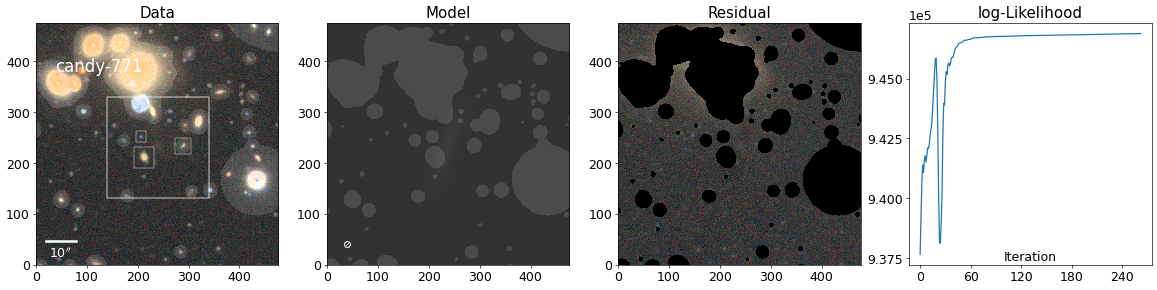

In [175]:
try:
    fitter._find_sed_ind()
    fitter._gen_final_mask()
    fitter._display_results()
except:
    pass

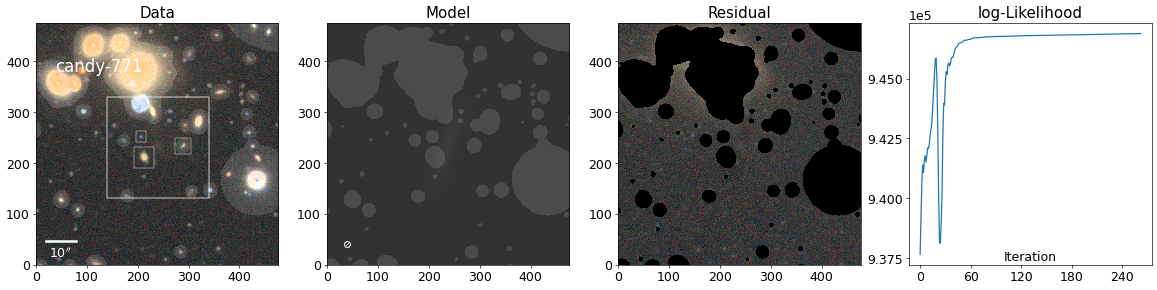

In [176]:
fitter._display_results()

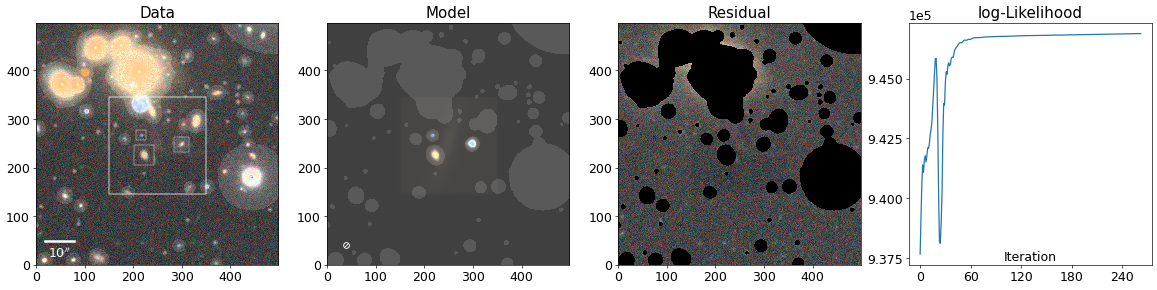

In [177]:
fig = kz.display.display_scarlet_results_tigress(
        fitter._blend,
        fitter.final_mask,
#         show_ind=fitter.sed_ind,
#         zoomin_size=50,
        minimum=-0.2,
        stretch=0.7,
        Q=1,
        channels=fitter.data.channels,
        show_loss=True,
        show_mask=False,
        show_mark=False,
        scale_bar=True)

In [178]:
from kuaizi.measure import cal_cnu
david = fitter.blend.sources[0]
print(david.get_parameter(3) * 0.168)
sed, morph = david.get_models_of_children()
true_flux = (2 * np.pi * david.parameters[3]**2) / cal_cnu(david.parameters[2])**2
print('mag:', -2.5 * np.log10(true_flux * sed) + 27.0)
print('Sky:', -2.5 * np.log10(fitter.blend.sources[-1].get_model().mean(axis=(1, 2)) / 0.168**2) + 27)

[[6.0317901]]
mag: [[22.19781685 21.55960987 21.23980263 20.9909414 ]]
Sky: [28.59161716 27.98391848 27.54915675 27.10306203]


In [65]:
from kuaizi.measure import makeMeasurement, makeMeasurementMockGal

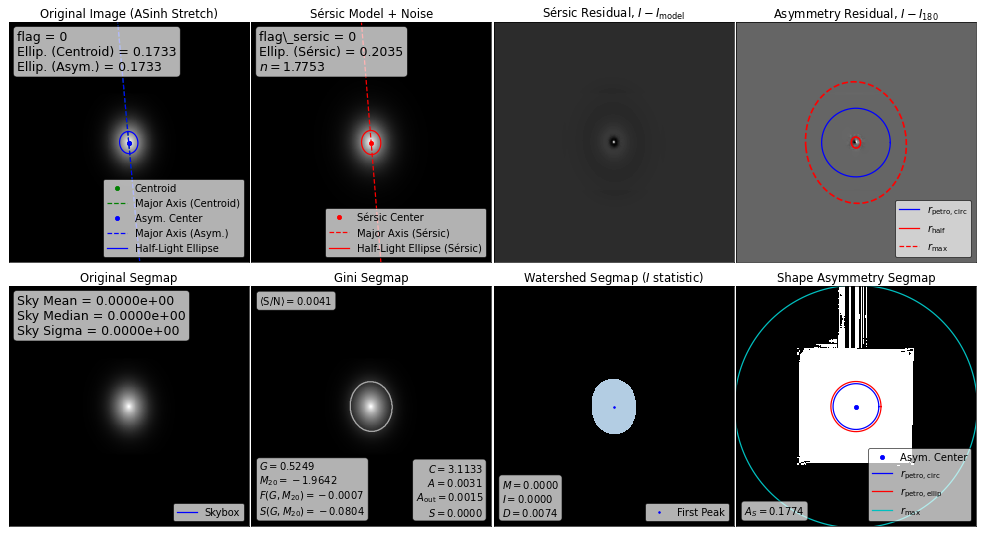

In [70]:
measurement, t = makeMeasurement(list(np.array(fitter.blend.sources)[fitter.sed_ind]),
                                 fitter.blend.observations[0],
                                 aggr_mask=fitter.final_mask.astype(bool),
                                 makesegmap=False, sigma=0.02,
                                 method='spergel',
                                 zeropoint=27.0, out_prefix=None,
                                 show_fig=True, asinh_a=0.02, framealpha=0.7)
#row = _write_to_row(row, measurement)

In [123]:
# Sky SB
-2.5 * np.log10(fitter.blend.sources[-1].get_model().mean(axis=(1, 2)) / 0.168**2) + 27

Parameter([27.80146709, 27.02953743, 26.84623315, 26.54495943])

In [124]:
27 - 2.5 * np.log10(measurement['flux'])

array([22.5899559 , 21.86365037, 21.56390445, 21.43734834])

In [72]:
measurement['SB_eff_avg']

array([24.39634281, 23.76900643, 23.49439027, 23.35104114])

In [73]:
print(measurement['rhalf_circularized'] * 0.168)
print(measurement['sersic_rhalf'] * 0.168)
print(measurement['rhalf_spergel'] * 0.168)

3.520087276960531
4.223803090252271
3.4576251535270863


In [129]:
measurement['SB_eff_avg']

array([25.89437545, 25.16806992, 24.868324  , 24.74176789])

In [130]:
lsbg

<Row index=0>
  UV   viz-id     ra      dec        iSB          e_iSB     mag_auto_i  e_imag   g-r     g-i     Reff   e_Reff    n      e_n     Ell    e_Ell     Ag      Ar      Ai   recno flux_radius_ave_i cutout_size                            prefix                               RA      DEC    radius image_flag [5] psf_flag [5]
                                mag / arcsec2 mag / arcsec2    mag       mag     mag     mag    arcsec  arcsec                                   mag     mag     mag               arcsec                                                                                                 arcmin                            
bytes1 int16   float64  float64    float64       float64     float64   float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 float64 int32      float64        float64                             bytes59                            float64  float64 float64      bool          bool    
------ ------ --------- ------- ------------- ------------- ---------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ------- ----- ----------------- ----------- ----------------------------------------------------------- --------- ------- ------- -------------- ------------
          413 131.82191  1.9024         23.49           0.4      21.08    0.25    0.76     1.0    4.36    0.81    1.33    0.32    0.63    0.03   0.104   0.074   0.052   413              4.36         0.7 /scratch/gpfs/jiaxuanl/Data/HSC/LSBG/Cutout/candy/candy_413 131.82191  1.9024     0.7   True .. True True .. True

In [104]:
print(measurement['rhalf_circularized'] * 0.168)
print(gal.model.info['comp'][0]['model_params']['half_light_radius'])
measurement['sersic_rhalf'] * 0.168 * np.sqrt(1 - measurement['ellipticity_asymmetry'])

4.914961939897793
4.556496604388463


5.068036433903733

In [105]:
measurement['SB_eff_avg'], measurement['mag']

(array([25.790022, 25.45826 , 25.405367, 25.216639], dtype=float32),
 array([20.323706, 19.991943, 19.93905 , 19.75032 ], dtype=float32))

In [106]:
-2.5 * np.log10(measurement['flux_circ']) + 27

array([20.344858, 20.013096, 19.960203, 19.771473], dtype=float32)

In [107]:
gal.model.info['gmag'], gal.model.info['rmag'], gal.model.info['imag']

(20.420431085096865, 20.089120531929915, 19.987150741690147)

In [108]:
measurement['ellipticity_asymmetry'], 1 - gal.model.info['comp'][0]['shear_params']['q']

(0.12251074353348768, 0.1277100516230144)